In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from stumpy.floss import _cac
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
import os

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [2]:
df = pd.read_csv("https://zenodo.org/record/4276400/files/Semantic_Segmentation_TiltABP.csv?download=1")
df.head()

time     abp
0     0  6832.0
1     1  6928.0
2     2  6968.0
3     3  6992.0
4     4  6980.0

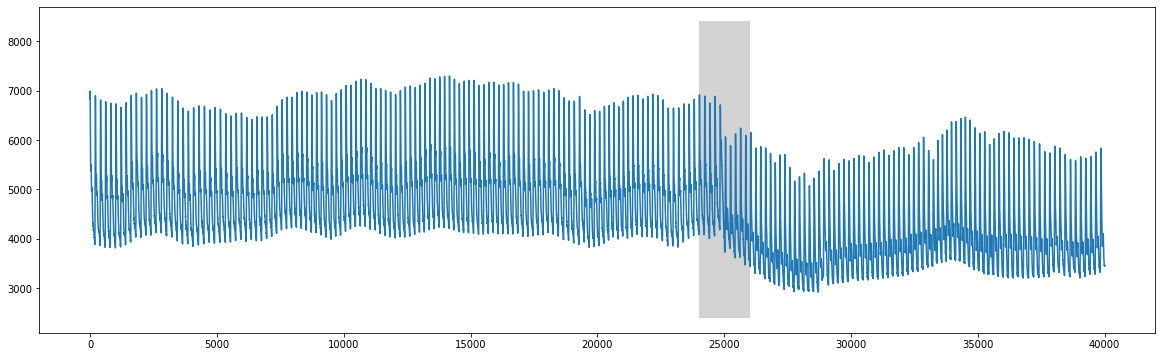

In [3]:
plt.plot(df['time'], df['abp'])
rect = Rectangle((24000,2400),2000,6000,facecolor='lightgrey')
plt.gca().add_patch(rect)
plt.show()

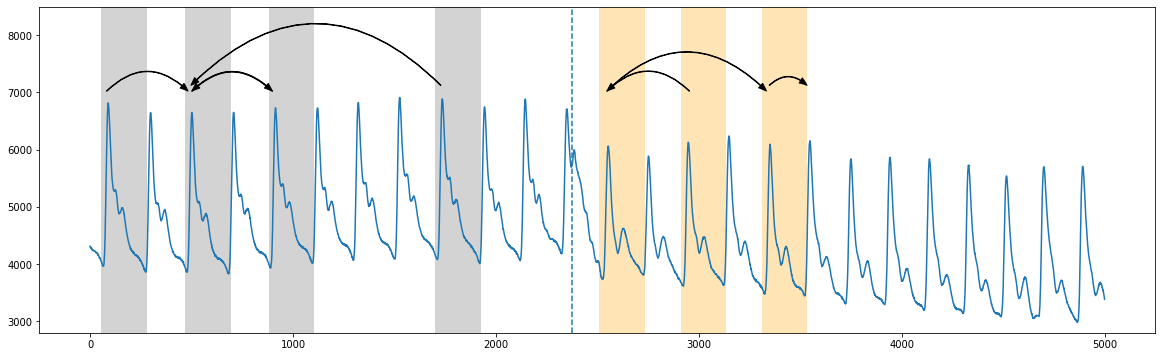

In [4]:
start = 25000 - 2500
stop = 25000 + 2500
abp = df.iloc[start:stop, 1]
plt.plot(range(abp.shape[0]), abp)
plt.ylim(2800, 8500)
plt.axvline(x=2373, linestyle="dashed")

style="Simple, tail_width=0.5, head_width=6, head_length=8"
kw = dict(arrowstyle=style, color="k")

# regime 1
rect = Rectangle((55,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((470,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((880,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
rect = Rectangle((1700,2500), 225, 6000, facecolor='lightgrey')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((75, 7000), (490, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((495, 7000), (905, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((905, 7000), (495, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((1735, 7100), (490, 7100), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)

# regime 2
rect = Rectangle((2510,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((2910,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
rect = Rectangle((3310,2500), 225, 6000, facecolor='moccasin')
plt.gca().add_patch(rect)
arrow = FancyArrowPatch((2540, 7000), (3340, 7000), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((2960, 7000), (2540, 7000), connectionstyle="arc3, rad=.5", **kw)
plt.gca().add_patch(arrow)
arrow = FancyArrowPatch((3340, 7100), (3540, 7100), connectionstyle="arc3, rad=-.5", **kw)
plt.gca().add_patch(arrow)

plt.show()

In [5]:
m = 210
mp = stumpy.stump(abp, m=m)
print(mp)

[[0.5964323211011386 412 -1 412]
 [0.5958821344591173 413 -1 413]
 [0.5968788669471666 414 -1 414]
 ...
 [0.889508409917072 4225 4225 -1]
 [0.8908030945093475 4226 4226 -1]
 [0.8934298784435781 4227 4227 -1]]


In [6]:
L = 210
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

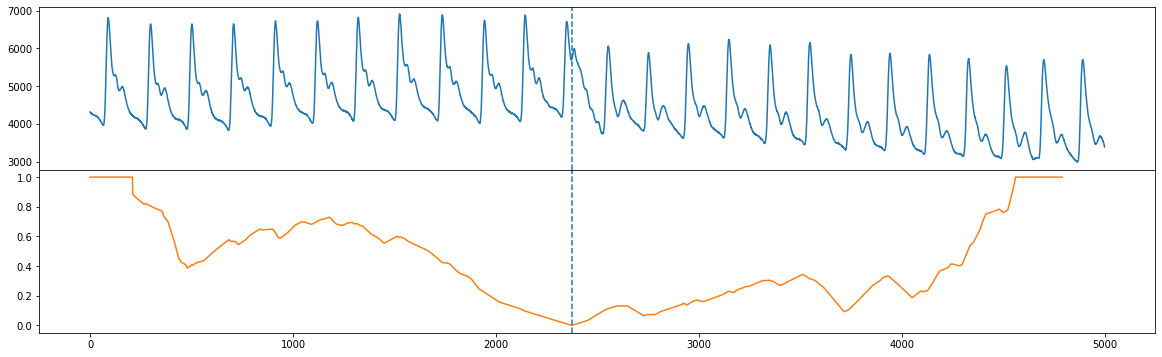

In [7]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
plt.show()

In [8]:
cac_1d = _cac(mp[:, 3], L, bidirectional=False, excl_factor=1)  # This is for demo purposes only. Use floss() below!

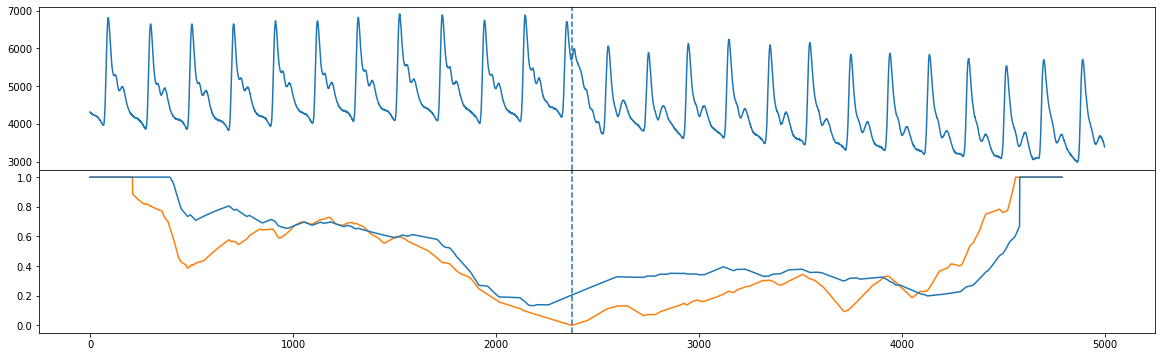

In [9]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)
plt.show()

In [10]:
old_data = df.iloc[20000:20000+5000, 1].values  # This is well before the regime change has occurred

mp = stumpy.stump(old_data, m=m)

In [11]:
new_data = df.iloc[25000:25000+5000, 1].values

In [12]:
stream = stumpy.floss(mp, old_data, m=m, L=L, excl_factor=1)

In [15]:
windows = []
for i, t in enumerate(new_data):
    stream.update(t)

    if i % 100 == 0:
        windows.append((stream.T_, stream.cac_1d_))

In [16]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})

axs[0].set_xlim((0, mp.shape[0]))
axs[0].set_ylim((-0.1, max(np.max(old_data), np.max(new_data))))
axs[1].set_xlim((0, mp.shape[0]))
axs[1].set_ylim((-0.1, 1.1))

lines = []
for ax in axs:
    line, = ax.plot([], [], lw=2)
    lines.append(line)
line, = axs[1].plot([], [], lw=2)
lines.append(line)

def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(window):
    data_out, cac_out = window
    for line, data in zip(lines, [data_out, cac_out, cac_1d]):
        line.set_data(np.arange(data.shape[0]), data)
    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=windows, interval=100,
                               blit=True)

anim_out = anim.to_jshtml()
plt.close()  # Prevents duplicate image from displaying
if os.path.exists("None0000000.png"):
    os.remove("None0000000.png")  # Delete rogue temp file

HTML(anim_out)
# anim.save('/tmp/semantic.mp4')